# Timeseries and met data based on paper that uses XGBoost

https://www.mdpi.com/2072-4292/13/6/1147/pdf

In [1]:
import xgboost as xgb

In [2]:
import json

import altair as alt
import httpx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely import geometry
from shapely.ops import unary_union
import os
from dotenv import load_dotenv

load_dotenv()  # take environment variables from .env.

True

In [3]:
from statsmodels.tsa.stattools import adfuller

# This is a stationary test for timeseries
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [4]:
tete_wb = ["1953", "1954", "1955", "1956", "1975", "1966", "1967", "1968", "1981", "1969", "1970", "1971", "1972", "1973", "1974", "1988"]
tete_aga = ["2363", "2189", "2190", "2191", "2202", "2192", "2193", "2194", "2203", "2195", "2196", "2197", "2198", "2199", "2200", "2201", "2204", "2205", "2206", "2208", "2209", "2207", "2210", "2211", "2212", "2213", "2214", "2215", "2216", "2359", "2360", "2361", "2362", "2364", "2365", "2366", "2367", "2368", "2369", "2370", "2371", "2372", "2409", "2410", "2411", "2412", "2413", "2414", "2415", "2454", "2416", "2452", "2453", "2455", "2456", "2459", "2457", "2458", "2460", "2461", "2462", "2463", "2464"]


tete_wb = list(map(int, tete_wb))
tete_aga = list(map(int, tete_aga))

# API Auth

In [5]:
base_url = "https://api.oxfordeo.com/"

In [6]:
client = httpx.Client(base_url=base_url)

In [7]:
r = client.post(
    "auth/token",
    data={"username": os.environ["API_USER"], "password": os.environ["API_PASS"]},
)

In [8]:
token = json.loads(r.text)["access_token"]
headers = {"Authorization": f"Bearer {token}"}

# Get agricultural areas geoms from the API

In [9]:
polygons = []
for wb_id in tete_aga:
    try:
        r = client.get("aoi/", params=dict(id=wb_id), headers=headers)
        res = json.loads(r.text)
        polygons.append(geometry.shape(res["features"][0]["geometry"]))
    except:
        continue

In [11]:
# get the bbox for all the ag areas
box = unary_union(polygons).bounds


# Get Events from DB 
- Date range from 2019 to 2022

In [12]:
start_datetime = "2017-01-02"
end_datetime = "2021-12-31"

In [13]:
aga_results = []
for aoi in tete_aga:
    r = client.get(
        "events/",
        params=dict(
            aoi_id=aoi,
            start_datetime=start_datetime,
            end_datetime=end_datetime,
            limit=10000,
        ),
        headers=headers,
        timeout=60,
    )
    aga_results.extend(json.loads(r.text)["events"])
    
wb_results = []
for aoi in tete_wb:
    r = client.get(
        "events/",
        params=dict(
            aoi_id=aoi,
            start_datetime=start_datetime,
            end_datetime=end_datetime,
            limit=10000,
        ),
        headers=headers,
        timeout=60,
    )
    wb_results.extend(json.loads(r.text)["events"])

In [14]:
def get_keyed_values(results, keyed_value, new_col):
    df = pd.DataFrame(results)
    df.labels = df.labels.map(lambda x: x[0])
    df[new_col] = df.keyed_values.apply(lambda x: x.get(keyed_value))
    df = df.drop_duplicates(subset=["aoi_id", "datetime"]).dropna()
    df.datetime = pd.to_datetime(df.datetime)
    return df
    

In [15]:
aga_df = get_keyed_values(aga_results, "mean_value", "ndvi_mean")
wb_df = get_keyed_values(wb_results, "water_pixels", "water_pixels")

In [16]:
# TODO: We don't have water pixels for all the dates, we should run the predictions. 
# I'm not using water pixels predictions from now on to avoid problems.
aga_df.datetime.min(), aga_df.datetime.max(), wb_df.datetime.min(), wb_df.datetime.max()

(Timestamp('2017-01-02 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2020-12-10 00:00:00'),
 Timestamp('2021-01-31 00:00:00'))

# Get NDVI for given daterange
- Filter results by date
- Fill na values using forward fill (we don't an image for every single day)
- We need monthly data so we are using a monthly mean

In [17]:
ndvi=aga_df[(aga_df.datetime >= start_datetime) & (aga_df.datetime <= end_datetime)].groupby(["datetime"]).mean()["ndvi_mean"]

In [18]:
ndvi_monthly = ndvi.resample("M").mean()

<AxesSubplot:xlabel='datetime'>

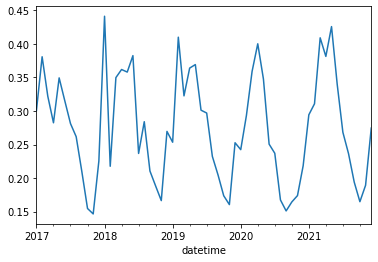

In [19]:
ndvi_monthly.plot()

# Get precipitation data from bucket
- Data is stored in zarr with dimensions: latitude, longitude, step, member and time
- step is synonym of "days forecast" (up to 215 days = 7 months). Shows acum TP (if we don't want acum, we can use df.diff)
- members are different forecast models (up to 50). We can average them
- time has a measure everymonth



In [21]:
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
url = 'gs://oxeo-seasonal/tp'
zx = xr.open_zarr(gcsfs.GCSMap(url)) 

In [22]:
min_x, min_y, max_x, max_y = box
min_x += 180
max_x += 180

In [23]:
from datetime import datetime
data = zx['tp'].sel({'time':slice(datetime.strptime(start_datetime, "%Y-%m-%d"),
                                  datetime.strptime(end_datetime, "%Y-%m-%d")),
                'latitude':slice(round(max_y),round(min_y)),
                'longitude':slice(round(min_x),round(max_x))})

In [24]:
data

<xarray.DataArray 'tp' (latitude: 3, longitude: 6, step: 215, member: 51,
                        time: 59)>
dask.array<getitem, shape=(3, 6, 215, 51, 59), dtype=float32, chunksize=(2, 4, 215, 51, 12), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) int64 -16 -17 -18
  * longitude  (longitude) int64 210 211 212 213 214 215
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * step       (step) timedelta64[ns] 1 days 2 days 3 days ... 214 days 215 days
  * time       (time) datetime64[ns] 2017-02-01 2017-03-01 ... 2021-12-01

## Getting monthly tp data
We have monthly measures and for each month we have 215 days of forecast data. 
We need current month prediction, and the cumulative of 2 and 3 months.


In [25]:
def get_tp_cumsum(data, window=1):
    cum_tp = data.mean(dim=["latitude", "longitude"]).isel(step=30).mean(dim="member").values
    return pd.Series(cum_tp, index=data.time.values).rolling(min_periods=1, window=window).sum()


In [26]:
tp_monthly = get_tp_cumsum(data, window=1)
tp_monthly_2_cumsum = get_tp_cumsum(data, window=2)
tp_monthly_3_cumsum = get_tp_cumsum(data, window=3)

In [27]:
# 2017-02-01 means cumsum in february. So, that's the predicted
# cumsum at the beginning of march. So I'm gonna shift the values
tp_monthly.head()

2017-02-01    0.248888
2017-03-01    0.152981
2017-04-01    0.144664
2017-05-01    0.106611
2017-06-01    0.070889
dtype: float64

tp_monthly = tp_monthly.shift(1).dropna()
tp_monthly_2_cumsum = tp_monthly_2_cumsum.shift(1).dropna()
tp_monthly_3_cumsum = tp_monthly_3_cumsum.shift(1).dropna()

<AxesSubplot:>

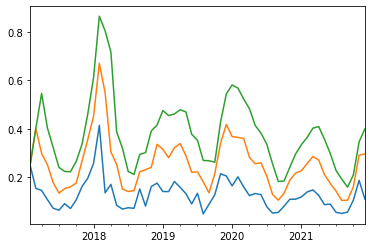

In [28]:
tp_monthly.plot()
tp_monthly_2_cumsum.plot()
tp_monthly_3_cumsum.plot()

# XGBoost model
We have now 4 explanatory variables:
- Last month NDVI
- Last month TP
- Last 2 months cum TP
- Last 3 months cum TP

and we want to predict next month NDVI


In [29]:
ndvi_monthly.tail(1), tp_monthly.tail(1)

(datetime
 2021-12-31    0.274586
 Freq: M, Name: ndvi_mean, dtype: float64,
 2021-12-01    0.10908
 dtype: float64)

In [30]:
ndvi_monthly.shape, tp_monthly.shape

((60,), (59,))

In [31]:
# Shift ndvi. I'm using last mont ndvi mean, and tp_monthly forecast 
ndvi_monthly = ndvi_monthly[:-1]

In [32]:
# tp_monthly dates are like 2019-01-01, and ndvi_monthly are 2019-01-31. 
# that's why I take the index from 1: and not 0

ndvi_monthly.index = tp_monthly.index


In [33]:
# Gotta remove first 2 values because I'm using last 3 months cumsum, and the first entries 
# don't have this cumsum
tp_monthly = tp_monthly[2:]
tp_monthly_2_cumsum = tp_monthly_2_cumsum[2:]
tp_monthly_3_cumsum = tp_monthly_3_cumsum[2:]
ndvi_monthly = ndvi_monthly[2:]


# Train 7 different models (one per forecasted month)

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit




cols = ["last_month_mean_ndvi", "tp_forecast_1_month_cumsum", "tp_last_2_month_cumsum", "tp_last_3_month_cumsum"]

# set target to one month in advance
models = []
for i in range(1,8):
    # gotta shift because ndvi is the average of the month and tp is the firt day of the month
    df = pd.concat([ndvi_monthly, tp_monthly, tp_monthly_2_cumsum, tp_monthly_3_cumsum], axis=1)
    df.columns = cols
    df["target"] = df["last_month_mean_ndvi"].shift(-i)

    #df.dropna(inplace=True)

    train = df[:-14]
    test = df[-14:-7]

    X_train =train[cols]
    X_test = test[cols]

    y_train = train.target
    y_test = test.target

    print(train.shape, test.shape)
    xg_reg = xgb.XGBRegressor()
    
    params = {'objective':['reg:squarederror'],
              'learning_rate': [.005, .008], #so called `eta` value
              'max_depth': [1,2,3,4],
              'n_estimators': [1000, 1500,2000]}
              

    xgb_grid = GridSearchCV(xg_reg,
                            params,
                            cv = TimeSeriesSplit(n_splits=3),
                            n_jobs = -1,
                            verbose=True)

    xgb_grid.fit(X_train,
             y_train)
    
    #xg_reg.fit(X_train.values,y_train)
    models.append(xgb_grid.best_estimator_)


(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits
(43, 5) (7, 5)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [71]:
X_test

,last_month_mean_ndvi,tp_forecast_1_month_cumsum,tp_last_2_month_cumsum,tp_last_3_month_cumsum
2020-11-01,0.164349,0.107995,0.187269,0.240725
2020-12-01,0.173868,0.108342,0.216337,0.295611
2021-01-01,0.218360,0.117621,0.225963,0.333957
2021-02-01,0.294321,0.138243,0.255864,0.364206
2021-03-01,0.310769,0.146778,0.285021,0.402642
2021-04-01,0.409111,0.124220,0.270998,0.409241
2021-05-01,0.381401,0.085730,0.209950,0.356729


In [86]:
# Predict using 7 models, always use as entry X_test[0]
preds = []
for i in range(7):
    preds.append(models[i].predict(X_test.values[0].reshape(1,-1))[0])

<AxesSubplot:>

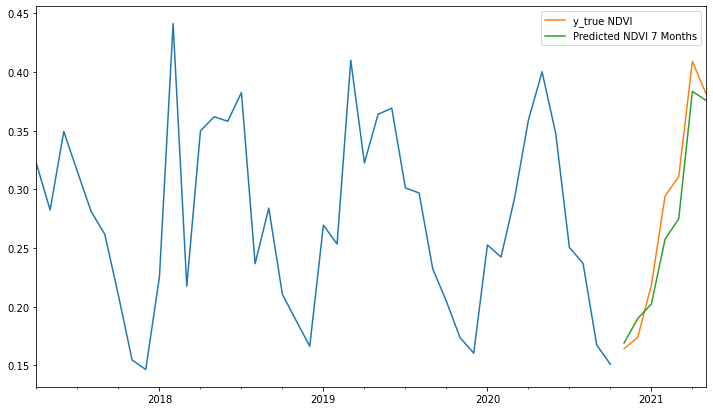

In [90]:
plt.figure(figsize=(12,7))
X_train.last_month_mean_ndvi.plot()
X_test.last_month_mean_ndvi.plot(label="y_true NDVI", legend=True)
pd.Series(preds, index=X_test.index[:7]).plot(label="Predicted NDVI 7 Months", legend=True)